In [3]:
from typing import *
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers

# Import state tomography modules
from qiskit_experiments.library import StateTomography
from osp_solutions.patch_ignis import rename_qcs_StateTomography_to_ignis
from osp_solutions.tomography import StateTomographyFitter
from qiskit.quantum_info import state_fidelity

from osp_solutions.circuits import append_block_trotter, append_block_trotter_proposed, append_initial_state, append_block_trotter_aj, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
# from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")

simulator_ideal = AerSimulator(method="density_matrix")

from qiskit.circuit import QuantumCircuit, Instruction, Parameter # , QuantumRegister

In [4]:
def gate_U_negishi(dt, 
                   option: str = "a",
                   to_instruction: bool = True,
                   add_barrier: bool = False,
                  ) -> Union[QuantumCircuit, Instruction]:
    """
    dt: qiskit._accelerate.circuit.Parameter
    Create and return the circuit instruction of the one trotter step with rotation angle `dt`.
    """

    theta = np.pi / 2 - 2 * dt
    phi = - theta

    theta_negative_t = np.pi / 2 + 2 * dt
    phi_negative_t = - theta_negative_t
    
    qc = QuantumCircuit(2)

    if option == "a":
        qc.cx(0, 1)

        qc.rz(- np.pi / 2, 0)
        qc.ry(- phi, 0)
        qc.rz(- theta, 1)

        qc.cx(1, 0)

        qc.ry(- theta, 0)
        
        qc.cx(0, 1)

        qc.rz(np.pi / 2, 1)

    elif option == "b":
        qc.cx(1, 0)

        qc.rz(- np.pi / 2, 1)
        qc.ry(- phi, 1)
        qc.rz(- theta, 0)

        qc.cx(0, 1)

        qc.ry(- theta, 1)
        
        qc.cx(1, 0)

        qc.rz(np.pi / 2, 0)

    elif option == "c":
        qc.rz(- np.pi / 2, 1)

        qc.cx(0, 1)

        qc.ry(theta_negative_t, 0)

        qc.cx(1, 0)

        qc.rz(theta_negative_t, 1)
        qc.ry(phi_negative_t, 0)
        qc.rz(np.pi / 2, 0)

        qc.cx(0, 1)
        
    else:
        raise Exception
    
    if add_barrier:
        qc.barrier()

    return qc.to_instruction(label="Trotter") if to_instruction else qc

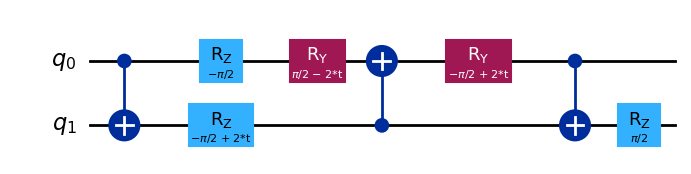

In [10]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "a",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")

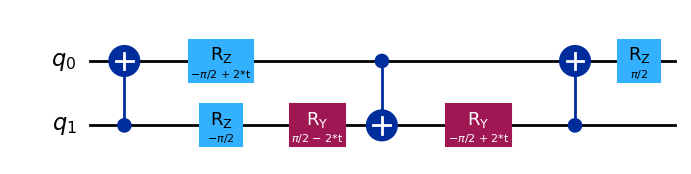

In [11]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "b",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")

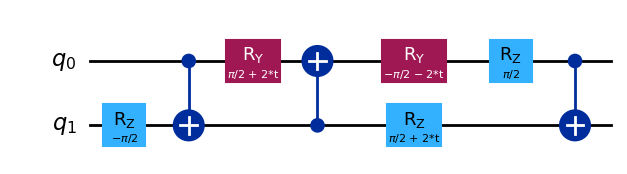

In [12]:
qc = gate_U_negishi(dt=Parameter("t"), 
                    option = "c",
                    to_instruction = False,
                    add_barrier = False,
                   )
qc.draw("mpl")